# 02 Projektive Entzerrung


Eine häufige Anwendung von projektiven Bildtransformationen ist die projektive Entzerrung:
Schrägaufnahmen von (annähernd) ebenen Objekten werden so transformiert, daß das Objekt
wie unter einer Senkrechtaufnahme erscheint. In der Vorlesung wurde gezeigt, wie man eine
geeignete Projektivtransformation aus vier Passpunkten berechnet. Die Abgabe erfolgt in
Form eines *Jupyter Notebooks*.

## Aufgaben

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread
from matplotlib.ticker import MaxNLocator

np.set_printoptions(precision=4, suppress=True)

In [171]:
def plot_image_points(img, o_i, b_i, tick_step=50):
    fig, ax = plt.subplots()
    ax.imshow(img)
    # plot points
    ax.scatter(b_i[:,0], b_i[:,1], label='b points')
    ax.scatter(o_i[:,0], o_i[:,1], label='o points')
    # draw outlines
    b_outline = np.vstack([b_i, b_i[0]])
    o_outline = np.vstack([o_i, o_i[0]])
    ax.plot(b_outline[:,0], b_outline[:,1])
    ax.plot(o_outline[:,0], o_outline[:,1])
    # annotate points
    for i, (x, y) in enumerate(b_i):
        ax.text(x, y, f'b{i+1}')
    for i, (x, y) in enumerate(o_i):
        ax.text(x, y, f'o{i+1}')
    # show pixel ticks and labels
    h, w = img.shape[:2]
    ax.set_xlim(0, w)
    ax.set_ylim(h, 0)                   # invert y-axis so origin is top-left
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xticks(np.arange(0, w+1, tick_step))
    ax.set_yticks(np.arange(0, h+1, tick_step))
    ax.tick_params(axis='both', which='major', labelsize=8, length=4)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

def display_images(images, descriptions=None, title=None):
    n = len(images)

    if descriptions is None:
        descriptions = ['Original', 'Transformed']

    descriptions = descriptions[:n] + [''] * max(0, n - len(descriptions))

    fig = plt.figure()

    if title:
        fig.suptitle(title)

    for i, img in enumerate(images, 1):
        ax = fig.add_subplot(1, n, i)
        ax.imshow(img)
        ax.axis('off')
        if descriptions[i - 1]:
            ax.set_title(descriptions[i - 1])

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def bilinear_neighbor(img, loc):
    if np.array_equal(loc, np.floor(loc)):
        return img[int(loc[1])][int(loc[0])]

    img_height, img_width = img.shape[:2]
    x0, y0 = int(np.floor(loc[0])), int(np.floor(loc[1]))

    if x0 < 0 or x0 + 1 >= img_width or y0 < 0 or y0 + 1 >= img_height:
        return 0

    adjacent_pixels = img[y0:y0+2, x0:x0+2]

    dx, dy = loc[0] - x0, loc[1] - y0

    return (adjacent_pixels[0,0] * (1 - dx) * (1 - dy)
            + adjacent_pixels[0,1] * dx       * (1 - dy)
            + adjacent_pixels[1,0] * (1 - dx) * dy
            + adjacent_pixels[1,1] * dx       * dy)

### Teil A
Suchen Sie in der Datei `schraegbild_tempelhof.jpg` vier markante Punkte im Bild (am einfachsten ist vermutlich ein großräumiges Rechteck). Vermessen Sie die genaue Bildposition dieser Punkte, indem Sie (z.B. mit Paint) das Bild in so groß wie möglich darstellen und die Position des Cursors in Pixeln anzeigen lassen. Diese Punkte stellen unsere Passpunkte dar, d.h. für die projektive Entzerrung brauchen wir für die vier Bildpunkte geeignete Weltkoordinaten. In unserem Fall sind das unsere Wunschkoordinaten im Zielbild, also einer entzerrten fiktiven Senkrechtaufnahme. Hier kann man z.B. einfach die vier Ecken des Zielbildes als Weltkoordinaten in der Einheit Pixel angeben. Markieren Sie die Passpunkte im Ausgangsbild ähnlich wie im gezeigten Beispiel (rot: Ausgangskoordinaten bi, blau: Zielkoordinaten oi).

![](images/tempelhof_rectified.png)

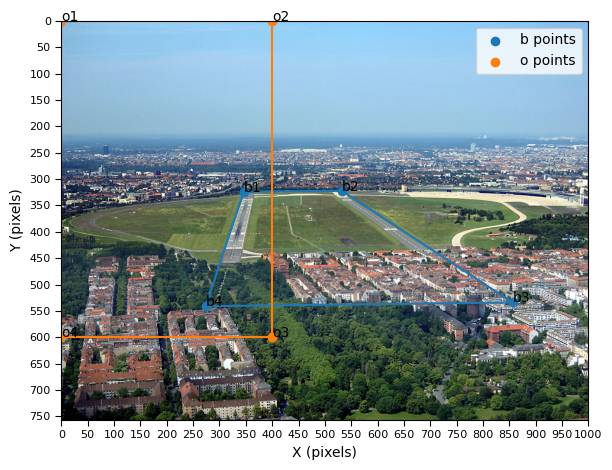

In [172]:
img = imread('./data/schraegbild_tempelhof.jpg')

b_i = np.array([
	[346, 324],
	[532, 322],
	[856, 534],
	[274, 541]
], dtype=int)

img_height, img_width = 600, 400
o_i = np.array([
        [0, 0],
        [img_width, 0],
        [img_width, img_height],
        [0,img_height]
    ])

plot_image_points(img, o_i, b_i)

### Teil B
Berechnen Sie dann, wie in der Vorlesung gezeigt, aus diesen vier Passpunkten eine geeignete projektive Transformation in Ihr Objektkoordinatensystem. Überprüfen Sie Ihr Ergebnis, indem Sie damit Ihre vier Weltkoordinaten $o_i$ in Bildkoordinaten $b^′_i$ transformieren.Diese sollten möglichst nahe zu den gemessenen Bildpositionen bi liegen.

In [173]:
matrix_a = []

for i in range(o_i.shape[0]):
    matrix_a.append([ o_i[i][0],   o_i[i][1], 1,  0,  0, 0, -b_i[i][0]*o_i[i][0], -b_i[i][0]* o_i[i][1], -b_i[i][0] ])
    matrix_a.append([ 0,  0, 0,  o_i[i][0],   o_i[i][1], 1, -b_i[i][1]*o_i[i][0], -b_i[i][1]* o_i[i][1], -b_i[i][1] ])
matrix_a = np.vstack(matrix_a)

U, S, Vt = np.linalg.svd(matrix_a)
H = Vt[-1].reshape(3, 3)
H = H / H[2, 2]

print(H)

[[  0.4665  -0.431  346.    ]
 [ -0.0041  -0.2524 324.    ]
 [  0.      -0.0011   1.    ]]


In [174]:
o_h = np.hstack([o_i, np.ones((o_i.shape[0],1))])

b_proj = H.dot(o_h.T).T
b_proj = b_proj[:, :2] / b_proj[:, 2:3]

errors    = b_proj - b_i
distances = np.linalg.norm(errors, axis=1)
df = pd.DataFrame({
    'b_i_x':     b_i[:,0],
    'b_i_y':     b_i[:,1],
    'b_proj_x':  b_proj[:,0],
    'b_proj_y':  b_proj[:,1],
    'error_px':  distances
})
display(df.round(3))

,b_i_x,b_i_y,b_proj_x,b_proj_y,error_px
0,346,324,346.0,324.0,0.0
1,532,322,532.0,322.0,0.0
2,856,534,856.0,534.0,0.0
3,274,541,274.0,541.0,0.0


### Teil C
Schreiben Sie eine Funktion analog zu Übungsblatt 1, mit der sich ein Bild eines ebenen Objektes projektiv transformieren läßt. Die Inverse der Projektivtransformation aus der Vorlesung für die indirekte Umbildung ist gegeben durch:
$$
x^` = \frac{(b_2 - c_2 b_3)x + (a_3 c_2 - a_2)\,y + a_2 b_3 - a_3 b_2}
           {(b_1 c_2 - b_2 c_1)x + (a_2 c_1 - a_1 c_2)\,y + a_1 b_2 - a_2 b_1}
$$

$$
y^` = \frac{(b_3 c_1 - b_1)\,x + (a_1 - a_3 c_1)\,y + a_3 b_1 - a_1 b_3}
           {(b_1 c_2 - b_2 c_1)x + (a_2 c_1 - a_1 c_2)\,y + a_1 b_2 - a_2 b_1}.
$$

In [175]:
def projective_transform(H, img, dst_height, dst_width):
    target_matrix = np.zeros((dst_height, dst_width, img.shape[2]), dtype=img.dtype)

    if np.linalg.det(H) == 0:
        print("Transformation not possible: det(A^-1) = 0")
        return target_matrix

    for y in range(dst_height):
        for x in range(dst_width):

            loc_h = H.dot([x, y, 1])
            loc = loc_h[:2] / loc_h[2]

            target_matrix[y][x] = bilinear_neighbor(img, loc)

    return target_matrix

# def projective_transform(H, img, dst_height, dst_width):
#     target = np.zeros((dst_height, dst_width, img.shape[2]), dtype=img.dtype)
#     H = np.linalg.inv(H)
#
#     for y in range(dst_height):
#         for x in range(dst_width):
#
#             denom = H[1][0]*H[2][1] - H[1][1]*H[2][0]*x + H[0][1]*H[2][0] - H[0][0]*H[2][1]*y + H[0][0]*H[1][1] - H[0][1]*H[1][0]
#             if denom == 0:
#                 continue
#
#             x_src = ((H[1][1] - H[2][1]*H[1][2])*x + (H[0][2]*H[2][1] - H[0][1])*y + (H[0][1]*H[1][2] - H[0][2]*H[1][1])) / denom
#             y_src = ((H[1][2]*H[2][0] - H[1][0])*x + (H[0][0] - H[0][2]*H[2][0])*y + (H[0][2]*H[1][0] - H[0][0]*H[1][2])) / denom
#
#             target[y, x] = bilinear_neighbor(img, [x_src, y_src])
#
#     return target

### Teil D
Erstellen Sie mit dieser Funktion aus der Datei `schraegbild_tempelhof.jpg` eine fiktive Senkrechtaufnahme, d.h. eine Karte des abgebildeten Gebietes, bei dem wir die Höhe der Gebäude ignorieren.

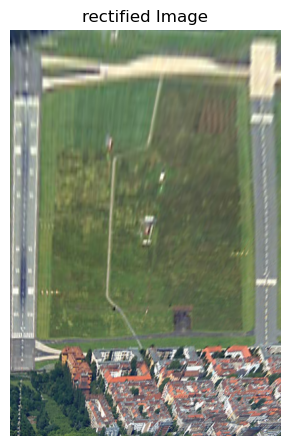

In [176]:
p_transformed = projective_transform(H, img, img_height, img_width)
display_images([p_transformed], ["rectified Image"])